In [189]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


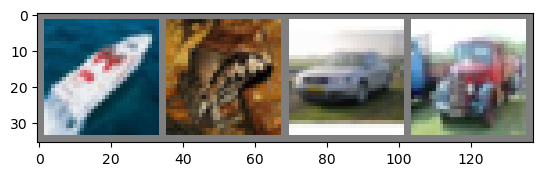

ship  frog  car   truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


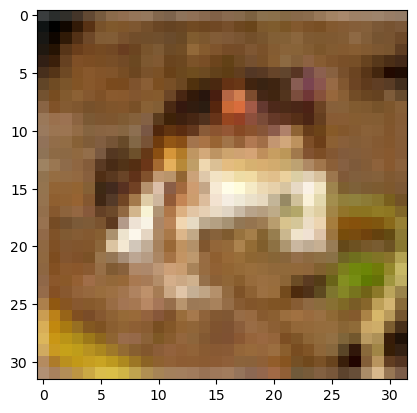

torch.Size([1, 3, 32, 32])


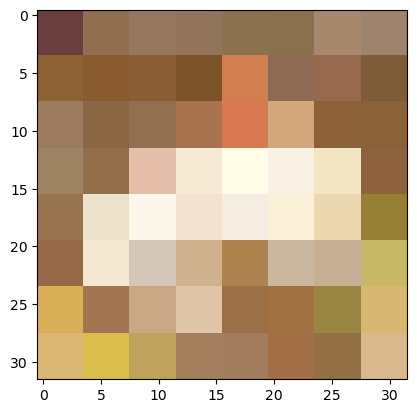

In [5]:
class Blur(nn.Module):
    def __init__(self):
        super(Blur, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.MaxPool2d(4)
        )

    def forward(self,x):
       x = self.layers(x)
       #print(x.shape)
       x = F.interpolate(x, size=(32, 32), mode='nearest')
       return x


def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

im, label = trainset[0]

effect = Blur()
#imshow(im)
im = torch.unsqueeze(im, 0)


blurredim = effect(im)
#print(blurredim.shape)
#imshow(torch.squeeze(blurredim))


In [275]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.00)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConvLayers = torch.nn.Sequential(
            nn.Conv2d(3, 96, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 192, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, stride=2, padding =1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 1),
            nn.ReLU(),
            nn.Conv2d(192, 10, 1),
            nn.AvgPool2d(2),
    
            #PrintLayer(),
            #Using Cross entropy loss so don't
            #need to apply softmax to output of last layer
        )

        #self.fc1 = nn.Linear(160, 80)
        self.fc2 = nn.Linear(40, 10)

    

    def forward(self, x):
        x = self.ConvLayers(x)
        x = torch.flatten(x, start_dim=1)
        #x = self.fc1(x)
        x = self.fc2(x)
        return x
    

model = CNN()
model.apply(init_weights)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

In [276]:
data_iter = iter(trainset)

for i in range(3):
    (data, label) = next(data_iter)
im = data
data = data.unsqueeze(0)
print(data.shape)
print('\n')


#print(model(data).shape)

torch.Size([1, 3, 32, 32])




model = CNN()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

In [277]:
epoch_list = []
minibatch_number_list = []
loss_list = []

In [278]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
       
        outputs = model(inputs)
        #print(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            epoch_list.append(epoch+1)
            minibatch_number_list.append(i+1)
            loss_list.append(running_loss/2000)

            
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.026
[1,  4000] loss: 1.704
[1,  6000] loss: 1.565
[1,  8000] loss: 1.513
[1, 10000] loss: 1.440
[1, 12000] loss: 1.404
[2,  2000] loss: 1.305
[2,  4000] loss: 1.260
[2,  6000] loss: 1.214
[2,  8000] loss: 1.191
[2, 10000] loss: 1.167
[2, 12000] loss: 1.154
[3,  2000] loss: 1.050
[3,  4000] loss: 1.032
[3,  6000] loss: 1.019
[3,  8000] loss: 1.013
[3, 10000] loss: 1.042
[3, 12000] loss: 1.012
[4,  2000] loss: 0.881
[4,  4000] loss: 0.919
[4,  6000] loss: 0.923
[4,  8000] loss: 0.939
[4, 10000] loss: 0.933
[4, 12000] loss: 0.910
[5,  2000] loss: 0.820
[5,  4000] loss: 0.803
[5,  6000] loss: 0.846
[5,  8000] loss: 0.839
[5, 10000] loss: 0.840
[5, 12000] loss: 0.863
[6,  2000] loss: 0.724
[6,  4000] loss: 0.738
[6,  6000] loss: 0.777
[6,  8000] loss: 0.781
[6, 10000] loss: 0.798
[6, 12000] loss: 0.799
[7,  2000] loss: 0.647
[7,  4000] loss: 0.684
[7,  6000] loss: 0.714
[7,  8000] loss: 0.724
[7, 10000] loss: 0.731
[7, 12000] loss: 0.754
[8,  2000] loss: 0.596
[8,  4000] 

<Axes: xlabel='None', ylabel='losses'>

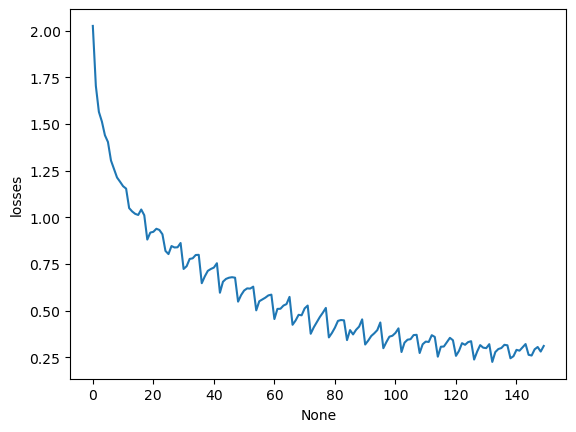

In [279]:
dic = {'losses':loss_list, 'epoch':epoch_list, "batch":minibatch_number_list}
df = pd.DataFrame(data=dic)

sns.lineplot(data=df, x=df.index, y='losses')

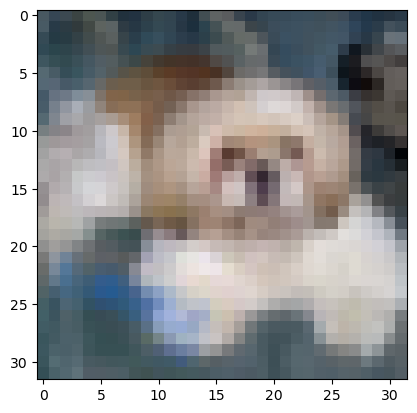

5
tensor([5])




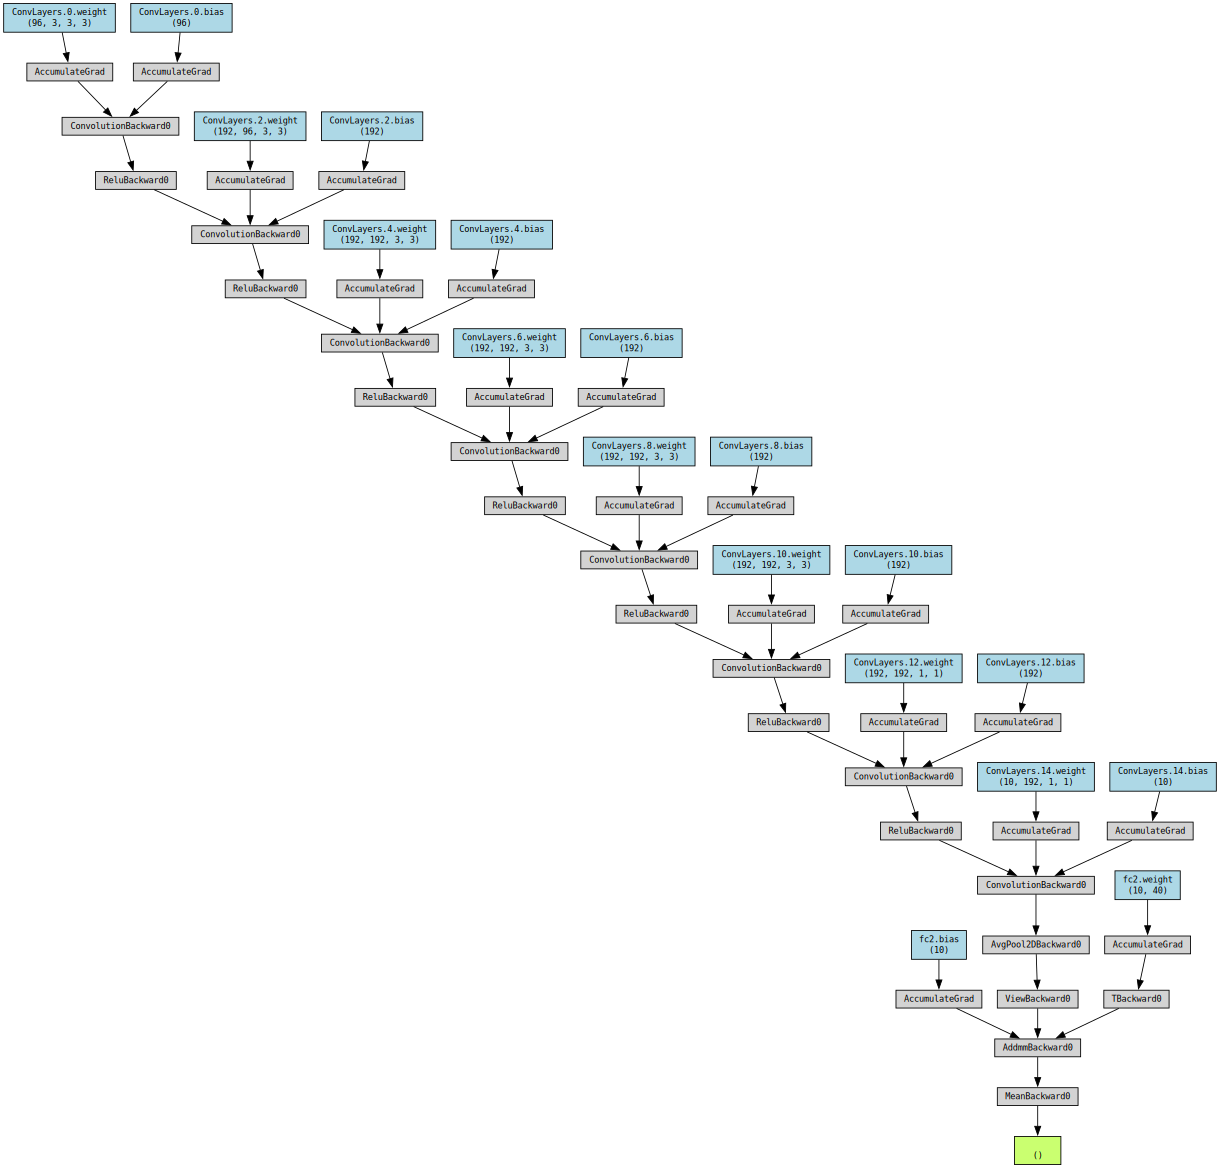

In [280]:
data_iter = iter(testset)

for i in range(40):
    (data, label) = next(data_iter)
im = data
data = data.unsqueeze(0)
soft = nn.Softmax(dim=1)
imshow(im)
print(label)

model_output = model(data)
prediction = soft(model_output)

_, ind = (torch.max(prediction, dim=1))
print(ind)
print("\n")


from torchviz import make_dot, make_dot_from_trace
make_dot(model_output.mean(), params=dict(model.named_parameters()))




In [281]:

running_samples_total = 0
correct_predictions_total = 0

for indx, data in enumerate(testloader):
    inputs, labels = data
    prediction = model(inputs)
    _, tensor_index = torch.max(prediction, dim=1)

    
    correct_predictions_total += (len(labels[labels==tensor_index]))
    running_samples_total += batch_size
    
    #if (indx >= 2):
    #    break

print (correct_predictions_total)
print(f"#Samples: {running_samples_total}     #Correct Predctions: {correct_predictions_total}      Accuracy:{correct_predictions_total/running_samples_total}")

6984
#Samples: 10000     #Correct Predctions: 6984      Accuracy:0.6984


### Code to save Model

In [282]:
#torch.save(model.state_dict(), "model_weights_v2")